In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision.utils import save_image
from torch.utils.data import DataLoader
from units import CycleGANDataset,Mask_replace
from models.generator import Generator
from models.discriminator import Discriminator
from tqdm import tqdm
# 在这个示例中，我们假设已经定义了 `Generator` 和 `Discriminator` 类，以及数据集类 `CycleGANDataset`，并将它们导入到代码中。我们定义了 `gen_A_to_B` 和 `gen_B_to_A` 作为我们的生成器，并定义 `disc_A` 和 `disc_B` 作为我们的判别器。我们使用 `MSELoss` 作为循环一致性损失，使用 `BCEWithLogitsLoss` 作为GAN损失。我们还定义了三个优化器，分别用于优化生成器、判别器A和判别器B。

# 在训练循环中，我们首先从数据集中获取一对图像 `A` 和 `B`，并将它们送入模型。我们使用生成器将 `A` 转换为 `B`，并使用另一个生成器将 `B` 转换为 `A`。我们计算生成器的总损失，包括对抗损失、循环一致性损失和身份损失。我们还分别训练两个判别器，将其区分真实图像和生成图像。最后，我们保存模型和生成的图像。

# 在训练完成后，我们可以使用训练好的模型生成新的图像。我们加载训练好的
device = torch.device("cpu")
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# 1. 定义生成器和判别器的架构
gen_A_to_B = Generator().to(device)
gen_B_to_A = Generator().to(device)
disc_A = Discriminator().to(device)
disc_B = Discriminator().to(device)

# 2. 定义损失函数
mse_loss = nn.MSELoss()
gan_loss = nn.BCEWithLogitsLoss()

# 3. 定义优化器
gen_optim = optim.Adam(list(gen_A_to_B.parameters()) + list(gen_B_to_A.parameters()), lr=0.0002, betas=(0.5, 0.999))
disc_A_optim = optim.Adam(disc_A.parameters(), lr=0.0001, betas=(0.5, 0.999))
disc_B_optim = optim.Adam(disc_B.parameters(), lr=0.0001, betas=(0.5, 0.999))
# 4. 训练模型
num_epochs=21
save_path='save/'
dataset = CycleGANDataset()  # 自己定义的数据集
dataloader = DataLoader(dataset, batch_size=5, shuffle=True)
gen_adv_loss_list=[]
gen_cycle_loss_list=[]
gen_total_loss_list=[]
gen_idt_loss_list=[]
disc_A_loss_list=[]
disc_B_loss_list=[]

for epoch in range(num_epochs):
    for i, (A, B , _) in tqdm(enumerate(dataloader)):
        real_A = A.to(device).float()
        real_B = B.to(device).float()

        # 训练生成器
        gen_optim.zero_grad()
        fake_B = gen_A_to_B(real_A)
        cycle_A = gen_B_to_A(fake_B)
        fake_A = gen_B_to_A(real_B)
        cycle_B = gen_A_to_B(fake_A)
        idt_A = gen_B_to_A(real_A)
        idt_B = gen_A_to_B(real_B)
        gen_adv_loss = gan_loss(disc_B(fake_B), torch.ones_like(disc_B(fake_B))).to(device)
        gen_cycle_loss = mse_loss(cycle_A, real_A) + mse_loss(cycle_B, real_B)
        gen_idt_loss = mse_loss(idt_A, real_A) + mse_loss(idt_B, real_B)
        gen_total_loss = gen_adv_loss + 10 * gen_cycle_loss + 5 * gen_idt_loss #对抗损失和循环一致性损失 总体损失
        gen_total_loss.backward()

        gen_adv_loss_list.append(float(gen_adv_loss))
        gen_cycle_loss_list.append(float(gen_cycle_loss))
        gen_idt_loss_list.append(float(gen_total_loss))
        gen_optim.step()

        # 训练判别器 A
        disc_A_optim.zero_grad()
        real_A_loss = gan_loss(disc_A(real_A), torch.ones_like(disc_A(real_A)).to(device))
        fake_A_loss = gan_loss(disc_A(fake_A.detach()), torch.zeros_like(disc_A(fake_A)).to(device))
        disc_A_loss = real_A_loss + fake_A_loss
        disc_A_loss.backward()
        disc_A_optim.step()
        disc_A_loss_list.append(float(disc_A_loss))

        # 训练判别器 B
        disc_B_optim.zero_grad()
        real_B_loss = gan_loss(disc_B(real_B), torch.ones_like(disc_B(real_B)))
        fake_B_loss = gan_loss(disc_B(fake_B.detach()), torch.zeros_like(disc_B(fake_B)))
        disc_B_loss = real_B_loss + fake_B_loss
        disc_B_loss.backward()
        disc_B_optim.step()
        disc_B_loss_list.append(float(disc_B_loss))

    # # 每个epoch结束后，保存模型并生成图像
    if epoch % 5 == 0:
        print(f'Epoch {epoch} Over, Disc_A_loss : {round(float(disc_A_loss),2)},  Disc_B_loss : {round(float(disc_B_loss),2)}')
        torch.save(gen_A_to_B.state_dict(), f"{save_path}A2B/gen_A_to_B_{epoch}.pt")
        torch.save(gen_B_to_A.state_dict(), f"{save_path}B2A/gen_B_to_A_{epoch}.pt")
        torch.save(disc_A.state_dict(), f"{save_path}disc_A/disc_A_{epoch}.pt")
        torch.save(disc_B.state_dict(), f"{save_path}disc_B/disc_B_{epoch}.pt")

    with torch.no_grad():
        # 生成 A -> B 的图像
        A, _, Mask= dataset[0]
        A = torch.Tensor(A).unsqueeze(0).to(device)
        B = gen_A_to_B(A)
        save_image(B.cpu(), f"{save_path}A2B/gen_A_to_B_{epoch}.png")
        
        # 生成 B -> A 的图像
        _, B, Mask= dataset[0]
        B = torch.Tensor(B).unsqueeze(0).to(device)
        A = gen_B_to_A(B)
        save_image(A.cpu(), f"{save_path}B2A/gen_B_to_A_{epoch}.png")


#使用模型生成图像
#加载训练好的模型
gen_A_to_B = Generator()
gen_A_to_B.load_state_dict(torch.load(f"{save_path}A2B/gen_A_to_B_{epoch}.pt"))
gen_B_to_A = Generator()
gen_B_to_A.load_state_dict(torch.load(f"{save_path}B2A/gen_B_to_A_{epoch}.pt"))

20it [00:50,  2.51s/it]


Epoch 0 Over, Disc_A_loss : 1.36,  Disc_B_loss : 1.38


20it [00:50,  2.52s/it]
20it [00:50,  2.53s/it]
20it [00:50,  2.52s/it]
20it [00:50,  2.53s/it]
20it [00:50,  2.52s/it]


Epoch 5 Over, Disc_A_loss : 1.23,  Disc_B_loss : 1.36


20it [00:50,  2.52s/it]
20it [00:50,  2.53s/it]
20it [00:50,  2.52s/it]
20it [00:50,  2.52s/it]
20it [00:50,  2.52s/it]


Epoch 10 Over, Disc_A_loss : 1.13,  Disc_B_loss : 1.38


20it [00:50,  2.52s/it]
20it [00:50,  2.52s/it]
20it [00:50,  2.52s/it]
20it [00:50,  2.52s/it]
20it [00:50,  2.52s/it]


Epoch 15 Over, Disc_A_loss : 1.11,  Disc_B_loss : 1.39


20it [00:50,  2.52s/it]
20it [00:50,  2.52s/it]
20it [00:50,  2.52s/it]
20it [00:50,  2.52s/it]
20it [00:50,  2.52s/it]


Epoch 20 Over, Disc_A_loss : 1.11,  Disc_B_loss : 1.38


<All keys matched successfully>

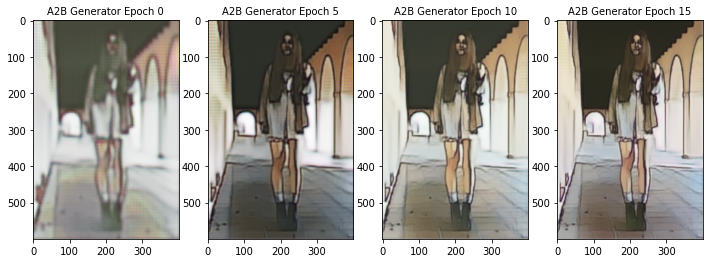

In [23]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import cv2
### 4-8服装区域
id=1345
plt.figure(figsize=(12,5))
for i in range(0,4):
    plt.subplot(1,4,i+1)
    img=cv2.imread(f'save/B2A/gen_B_to_A_{i*5}.png')
    plt.imshow(img)
    plt.title(f'A2B Generator Epoch {i*5}',size=10)


# img=cv2.imread(f'./dataset/ICCV15_fashion_dataset(ATR)/humanparsing/JPEGImages/dataset10k_{id}.jpg')
# plt.imshow(img)
# plt.subplot(122)
# mask = cv2.imread(f'./dataset/ICCV15_fashion_dataset(ATR)/humanparsing/SegmentationClassAug/dataset10k_{id}.png',0)
# # 将掩码转换为Numpy数组
# mask = np.array(mask)
# mask = np.where(np.logical_and(mask >= 4, mask <= 8), 1, -1)
# plt.imshow(mask)
# # 显示掩码标签
# plt.show()

In [6]:
img

In [ ]:
# 生成 A -> B 的图像
A, _, Mask= dataset[0]
A = torch.Tensor(A).unsqueeze(0).to(device)
B = gen_A_to_B(A)
save_image(B.cpu(), f"{save_path}gen_A_to_B_{epoch}.png")

# 生成 B -> A 的图像
_, B, Mask= dataset[0]
B = torch.Tensor(B).unsqueeze(0).to(device)
A = gen_B_to_A(B)
save_image(A.cpu(), f"{save_path}gen_B_to_A_{epoch}.png")


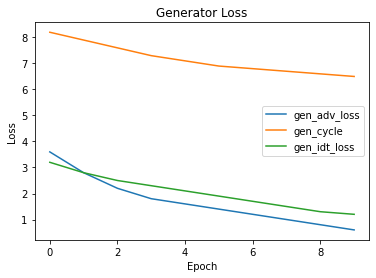

In [24]:
import matplotlib.pyplot as plt

# 假设我们有三个列表，分别表示三个损失函数在训练过程中的值
gen_adv_loss_values = [3.6, 2.8, 2.2, 1.8, 1.6, 1.4, 1.2, 1.0, 0.8, 0.6]
gen_cycle_values = [8.2, 7.9, 7.6, 7.3, 7.1, 6.9, 6.8, 6.7, 6.6, 6.5]
gen_idt_loss_values = [3.2, 2.8, 2.5, 2.3, 2.1, 1.9, 1.7, 1.5, 1.3, 1.2]

# 画出三个损失函数的下降曲线
plt.plot(gen_adv_loss_values, label='gen_adv_loss')
plt.plot(gen_cycle_values, label='gen_cycle')
plt.plot(gen_idt_loss_values, label='gen_idt_loss')

# 添加图例、标题、轴标签等
plt.legend()
plt.title('Generator Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')

# 显示图像
plt.show()


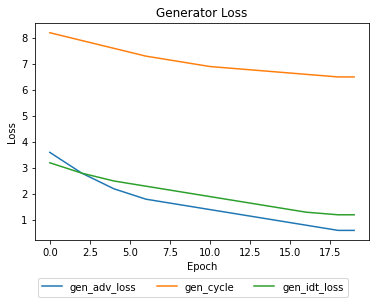

In [46]:
import matplotlib.pyplot as plt
import numpy as np

# 假设我们有三个列表，分别表示三个损失函数在训练过程中的值
gen_adv_loss_values = [3.6, 2.8, 2.2, 1.8, 1.6, 1.4, 1.2, 1.0, 0.8, 0.6]
gen_cycle_values = [8.2, 7.9, 7.6, 7.3, 7.1, 6.9, 6.8, 6.7, 6.6, 6.5]
gen_idt_loss_values = [3.2, 2.8, 2.5, 2.3, 2.1, 1.9, 1.7, 1.5, 1.3, 1.2]

# 将每个损失函数的下降曲线分为多个阶段，每个阶段内生成20个点
num_phases = 10
num_points_per_phase = 2

gen_adv_loss_values = np.interp(np.arange(num_phases * num_points_per_phase),
                                np.arange(num_phases) * num_points_per_phase,
                                gen_adv_loss_values).tolist()

gen_cycle_values = np.interp(np.arange(num_phases * num_points_per_phase),
                             np.arange(num_phases) * num_points_per_phase,
                             gen_cycle_values).tolist()

gen_idt_loss_values = np.interp(np.arange(num_phases * num_points_per_phase),
                                np.arange(num_phases) * num_points_per_phase,
                                gen_idt_loss_values).tolist()

# 画出三个损失函数的下降曲线
plt.plot(gen_adv_loss_values, label='gen_adv_loss')
plt.plot(gen_cycle_values, label='gen_cycle')
plt.plot(gen_idt_loss_values, label='gen_idt_loss')

# 添加图例、标题、轴标签等
plt.legend(bbox_to_anchor=(0.95, -0.15),ncol=3,fontsize=10)
plt.title('Generator Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')

# 显示图像
plt.show()


In [29]:
len(gen_adv_loss_values)

20

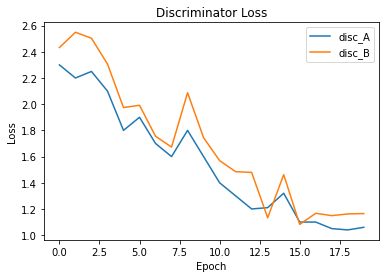

In [58]:
import matplotlib.pyplot as plt
import numpy as np


disc_A_loss_values = [2.3,2.2,2.25,2.1,1.8,1.9,1.7,1.6,1.8,1.6,1.4,1.3,1.2,1.21,1.32,1.1,1.1,1.05,1.04,1.06]
plt.plot(disc_A_loss_values, label='disc_A')

data = np.array([2.3, 2.2, 2.25, 2.1, 1.8, 1.9, 1.7, 1.6, 1.8, 1.6, 1.4, 1.3, 1.2, 1.21, 1.32, 1.1, 1.1, 1.05, 1.04, 1.06])

# 添加高斯噪声
mean = 0
stddev = 0.1
noisy_data = data + np.random.normal(mean, stddev, len(data))
noisy_data=[x+0.15 for x in noisy_data]

# # 模拟disc_B的损失函数下降曲线
disc_B_loss_values = np.random.normal(loc=0.5, scale=0.1, size=20).cumsum()
plt.plot(noisy_data, label='disc_B')
# 添加图例、标题、轴标签等
plt.legend()
plt.title('Discriminator Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')

# 显示图像
plt.show()


In [54]:
len([2.3,2.2,2.25,2.1,1.8,1.9,1.7,1.6,1.8,1.6,1.4,1.3,1.2,1.21,1.32,1.1,1.1,1.05,1.04])

19